In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

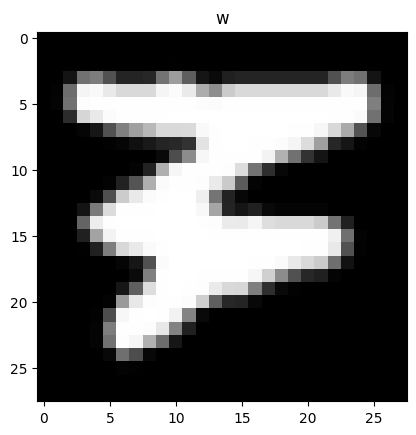

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
emnist = datasets.EMNIST(
    root='./data',
    split='letters',
    train=True,
    download=False,
    transform=transform
)
label = emnist[0][1]
plt.imshow(emnist[0][0][0], cmap='gray')
plt.title(chr(label + 96))  # 因为EMNIST的letters标签是1~26，所以+96得到ascii
plt.show()

In [3]:
# ===================== 1. 数据加载 =====================
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.EMNIST(
    root='./data',
    split='letters',
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.EMNIST(
    root='./data',
    split='letters',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# ===================== 2. 模型定义 =====================
from model.CNN import CNN

In [6]:
# ===================== 3. 损失函数和优化器 =====================
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [7]:
# ===================== 4. 训练和测试函数 =====================
from utils.train_model import train
from utils.eval_model import evaluate, evaluate_CNN



In [ ]:
# ===================== 4. 训练和测试函数 =====================
model = train(
    model=model, 
    x=train_loader, 
    y=None, 
    optimizer=optimizer, 
    criterion=criterion, 
    epochs=5, 
    patience=1, 
    device='mps'
)

Early stopping at epoch 5


In [ ]:



def train_one_epoch():
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        # EMNIST letters 标签是 1-26，我们要减1变成 0-25
        labels = labels - 1
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            labels = labels - 1
            output = model(imgs)
            pred = output.argmax(1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [36]:
# ===================== 5. 主训练循环 =====================
for epoch in range(5):
    loss = train_one_epoch()
    acc = evaluate()
    print(f"Epoch {epoch+1}: loss={loss:.4f}, test_acc={acc:.4f}")

# torch.save(model.state_dict(), "emnist_simplecnn.pth")
print("训练完成，模型已保存。")

Epoch 1: loss=1.0398, test_acc=0.8086
Epoch 2: loss=0.5621, test_acc=0.8489
Epoch 3: loss=0.4684, test_acc=0.8575
Epoch 4: loss=0.4240, test_acc=0.8727
Epoch 5: loss=0.3946, test_acc=0.8705
训练完成，模型已保存。
